In [1]:
!pip install seaborn
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import torch
import torch.distributions as dist
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from datetime import datetime
#%matplotlib notebook
random_seed = 1
np.random.seed(seed=1)
torch.manual_seed(2)
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
path = os.path.join(os.getcwd(), "plot/")
today=datetime.today().strftime('%Y-%m-%d')

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
class FHatNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FHatNetwork, self).__init__()
        layers = []
        if hidden_sizes == []:
            self.model = nn.Linear(input_size, output_size)
        else:
            layers.append(nn.Linear(input_size, hidden_sizes[0]))
            layers.append(nn.ReLU())
            for i in range(1, len(hidden_sizes)):
                layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
                layers.append(nn.ReLU())
            layers.append(nn.Linear(hidden_sizes[-1], output_size))
            self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)




# Define the target network
class TargetNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(TargetNetwork, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        return self.fc(x)

# Define the hypernetwork
class HyperNetwork(nn.Module):
    def __init__(self, target_net, hyper_input_dim, hyper_hidden_dims):
        super(HyperNetwork, self).__init__()
        self.target_net = target_net
        layers = [] 
        if hyper_hidden_dims == []:
            layers.append(nn.Linear(hyper_input_dim, target_net.fc.weight.numel()))
        else:
            layers.append(nn.Linear(hyper_input_dim, hyper_hidden_dims[0]))
            layers.append(nn.ReLU())
            for i in range(1, len(hyper_hidden_dims)):
                layers.append(nn.Linear(hyper_hidden_dims[i-1],hyper_hidden_dims[i]))
            layers.append(nn.Linear(hyper_hidden_dims[-1], target_net.fc.weight.numel()))
        
        layers.append(nn.Tanh())
        self.model = nn.Sequential(*layers)
        
    def forward(self, x, alpha):
        alpha = alpha.unsqueeze(0)
        params = self.model(alpha)
        params = params.view(self.target_net.fc.weight.size())
        self.target_net.fc.weight.data = params
        return self.target_net(x)

**Preliminaries** In the following, the classes are defined to initiate the aggregation functions $\rho_{\alpha}$ and the aggregated risk minimization (ARM) optimization for a simple 1D and 2D regression task.

In [6]:
class aggregation_function:    
    """ This class aggregates the risks. """
    def __init__(self, name:str):
        self.name = name
    def aggregate(self, risks, alpha) -> float:
        if self.name == 'cvar':
            return self.cvar(risks, alpha)
        else:
            raise NotImplementedError("Currently, only CVaR is implemented.")
    def cvar(self, risks, alpha) -> float:
        var = torch.quantile(risks,alpha, interpolation='linear')
        cvar = risks[risks > var].mean()
        return cvar

In [7]:
class ARM_Regression:
    def __init__(self, name, experiment="1D_linear"):      
        self.aggregator = aggregation_function(name=name)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def monte_carlo_cvar_estimate(self, risks, dist="uniform", true_alpha=0.5, num_samples=100):
        if dist == "uniform":
            alphas = np.random.uniform(low=0, high=1, size=num_samples)
            alphas = torch.tensor(alphas, dtype=torch.float32).to(self.device)
        else:
            # Generate samples from a normal distribution
            alphas = torch.normal(mean=true_alpha, std=1.0, size=(num_samples,))
            alphas = torch.clamp(alphas, min=0.0, max=1.0).to(self.device)
        
        cvar_estimates = [self.aggregator.aggregate(risks, alpha) for alpha in alphas]
        cvar_estimates = torch.stack(cvar_estimates)
        average_cvar = torch.mean(cvar_estimates)
        return average_cvar
    
    def train_together(self, f, env_dict, dist="uniform", true_alpha=0.5):
        learning_rate = 0.01
        num_epochs= 100
        d = env_dict[0]['x'].shape[1]
        loss_fn = torch.nn.MSELoss()        
        optimizer = torch.optim.Adam(f.parameters(), lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=100, gamma=0.1)
        for epoch in range(num_epochs):
            risks = torch.stack([loss_fn(env_dict[e]['y'].cuda(),f(env_dict[e]['x'].cuda())) for e in env_dict.keys()])
            avg_cvar = self.monte_carlo_cvar_estimate(risks, dist, true_alpha, num_samples=10)
            avg_cvar.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            if (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_cvar.item()}")
        return 


    def monte_carlo_h(self, h, env_dict, loss_fn, num_samples=100):
        cvar_estimates = []
        for _ in range(num_samples):
            alpha = np.random.uniform(low=0, high=1)
            alpha = torch.tensor(alpha, dtype=torch.float32).to(self.device)
            risks = torch.stack([loss_fn(env_dict[e]['y'].cuda(),h(env_dict[e]['x'].cuda(), alpha)) for e in env_dict.keys()])
            cvar_sample = self.aggregator.aggregate(risks, alpha)
            cvar_estimates.append(cvar_sample)
        
        cvar_estimates = torch.stack(cvar_estimates)
        average_cvar = torch.mean(cvar_estimates)
        return average_cvar
    
    def fit_h_new(self, h, env_dict):
        learning_rate = 0.01
        num_epochs= 100
        d = env_dict[0]['x'].shape[1]
        loss_fn = torch.nn.MSELoss()        
        optimizer = torch.optim.Adam(h.parameters(), lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=100, gamma=0.1)
        for epoch in range(num_epochs):
            avg_cvar = self.monte_carlo_h(h, env_dict, loss_fn, num_samples=100)
            avg_cvar.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            if (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_cvar.item()}")
        return 
    
    def fit_f(self, f, env_dict, alpha):        
        learning_rate = 0.01
        num_epochs= 200
        d = env_dict[0]['x'].shape[1]
        loss_fn = torch.nn.MSELoss()        
        optimizer = torch.optim.Adam(f.parameters(), lr=learning_rate)
        scheduler = StepLR(optimizer, step_size=100, gamma=0.1)
        for epoch in range(num_epochs):
            risks = torch.stack([loss_fn(env_dict[e]['y'].cuda(),f(env_dict[e]['x'].cuda())) for e in env_dict.keys()])
            cvar = self.aggregator.aggregate(risks, alpha)
            cvar.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            if (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {cvar.item()}")
        return 


**Experiment 1** We assume the following *linear* data generation process $$Y(X) = X*\theta_{e}+\epsilon$$ and *nonlinear* data generation process $$Y(X) = sin(X*\theta_{e})+\epsilon$$.

**Experiment 1A** Assume a linear model $Y_{e}=\theta_{e}X+\epsilon$, where $X \sim \mathcal{N}(2,0.2)$ and $\epsilon\sim \mathcal{N}(0,0.1)$. We simulate different environments by drawing $\theta$ from a beta distribution $Beta(0.1,0.2)$. In total, we generate for 25 environments 100 observations each.

**Experiment 1B** Assume the same setting as in Experiment 1, however, in contrast, we simulate different environments by drawing $\theta$ from a uniform distribution $\ \mathcal{U}(0,1)$. In total, we generate for 25 environments 100 observations each.

In [8]:
class data_generator:
    
    """ This class generates the simulation data. """
    

    def __init__(self, envs_train = 25, envs_test = 25, 
                 size_train = 1000, size_test= 100, 
                 theta_dist="uniform",
                 dim=1):
        
        self.envs_train = envs_train
        self.envs_test = envs_test
        self.size_train = size_train
        self.size_test = size_test
        self.theta_dist = theta_dist
        self.dim = dim 
        
    def generate(self) -> dict:           
        env_list_train = [f'e_{i}' for i in range(1,self.envs_train+1,1)]
        env_dict_train = dict(list(enumerate(env_list_train)))
        env_list_test  = [f'e_{i}' for i in range(1,self.envs_test+1,1)]
        env_dict_test  = dict(list(enumerate(env_list_test)))
        
        
        for e_train in env_dict_train.keys():
            if self.theta_dist == "uniform": 
                distribution = dist.Uniform(0, 1)
            else:
                distribution = dist.Beta(0.1, 0.2)
            theta_true = distribution.sample((self.dim,1))
            x_train = dist.normal.Normal(loc=1.0/self.dim, scale=0.5).sample((self.size_train,self.dim))
            noise_train = dist.normal.Normal(loc=0, scale=0.05).sample((self.size_train,self.dim))
            y_train = (1.0/math.sqrt(self.dim))*x_train@theta_true + noise_train
            env_dict_train[e_train] = {'x': x_train,'y': y_train,'theta_true': theta_true}
            
        for e_test in env_dict_test.keys():
            if self.theta_dist == "uniform": 
                distribution = dist.Uniform(0, 1)
            else:
                distribution = dist.Beta(0.1, 0.2)
            theta_true = distribution.sample((self.dim,1))
            x_test = dist.normal.Normal(loc=1.0/self.dim, scale=0.5).sample((self.size_test,self.dim))
            noise_test = dist.normal.Normal(loc=0, scale=0.05).sample((self.size_test,self.dim))
            y_test = (1.0/math.sqrt(self.dim))*x_test@theta_true + noise_test
            env_dict_test[e_test] = {'x': x_test,'y': y_test,'theta_true': theta_true}
            
        return env_dict_train, env_dict_test

In [9]:
# Instantiate the target network and hypernetwork
dim = 1
target_net = TargetNetwork(input_dim=dim, output_dim=1)
h = HyperNetwork(target_net, hyper_input_dim=1, hyper_hidden_dims=[10]).cuda()
print(h.target_net.fc.weight.data.item())

0.22939014434814453


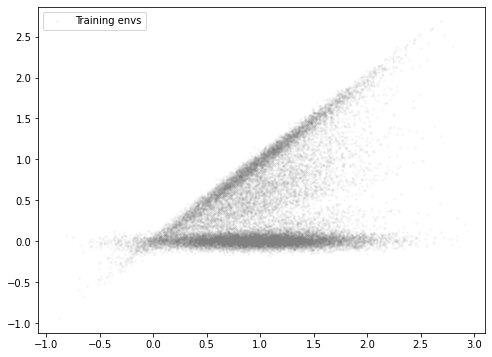

In [10]:
# Intitialize the experiment and generate the data
envs_train, envs_test = 250, 250
size_train, size_test = 100 , 100
theta_dist="beta" 
rho="cvar"

generator = data_generator(envs_train, envs_test, size_train, size_test, theta_dist, dim)
data_dict_train, data_dict_test = generator.generate()
# Define some example dimensions
generator = data_generator(envs_train, envs_test, size_train, size_test, theta_dist, dim)
data_dict_train, data_dict_test = generator.generate()
fig, ax = plt.subplots(1,1, figsize=(8,6))

X_train = [data_dict_train[e]['x'].ravel() for e in data_dict_train.keys()]
X_train = np.array([item for sublist in X_train for item in sublist]).reshape(-1,1)
Y_train = [data_dict_train[e]['y'] for e in data_dict_train.keys()]
Y_train = np.array([item for sublist in Y_train for item in sublist]).reshape(-1,1)

ax.scatter(y=Y_train, x=X_train, s=3, c="grey", alpha=0.05, label="Training envs")
ax.legend(loc='upper left')

Epoch [100/100], Loss: 0.3201998770236969


  0%|          | 0/20 [00:00<?, ?it/s]

alpha:  tensor(0.)  CVaR:  0.2378825843334198 param:  0.13534678518772125
alpha:  tensor(0.0500)  CVaR:  0.24902793765068054 param:  0.14188311994075775
alpha:  tensor(0.1000)  CVaR:  0.2601276636123657 param:  0.14840708673000336
alpha:  tensor(0.1500)  CVaR:  0.2715630531311035 param:  0.15491816401481628
alpha:  tensor(0.2000)  CVaR:  0.2809624671936035 param:  0.16141581535339355
alpha:  tensor(0.2500)  CVaR:  0.28938350081443787 param:  0.16789951920509338
alpha:  tensor(0.3000)  CVaR:  0.2963666319847107 param:  0.1743687242269516
alpha:  tensor(0.3500)  CVaR:  0.30335479974746704 param:  0.1808229237794876
alpha:  tensor(0.4000)  CVaR:  0.3098567724227905 param:  0.18726155161857605
alpha:  tensor(0.4500)  CVaR:  0.3166641891002655 param:  0.19368413090705872
alpha:  tensor(0.5000)  CVaR:  0.32268306612968445 param:  0.2000901699066162
alpha:  tensor(0.5500)  CVaR:  0.3285626173019409 param:  0.20647916197776794
alpha:  tensor(0.6000)  CVaR:  0.33467990159988403 param:  0.212850

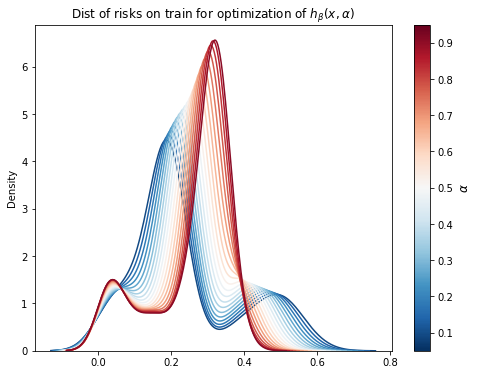

In [11]:
#Run the ARM regression task
loss_fn = torch.nn.MSELoss()
results = pd.DataFrame(columns = ["alpha", "cvar"])
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8,6))
rg = torch.arange(0,1,0.05)
diverging_colors = sns.color_palette("RdBu", len(rg))
ARM_Regression(name=rho).fit_h_new(h, data_dict_train) 
h.eval()
j=1
for alpha in tqdm(rg):
    with torch.no_grad():
        risks = torch.stack([loss_fn(data_dict_train[e]['y'].cuda(), h(data_dict_train[e]['x'].cuda(), alpha.cuda())) for e in data_dict_train.keys()])
        cvar_emp = aggregation_function(name="cvar").aggregate(risks.cpu(), alpha.cpu())     
        sns.kdeplot(risks.cpu().numpy(), ax=ax,color=diverging_colors[len(rg)-j], label=str(alpha.item()))
        print("alpha: ", alpha, " CVaR: ",cvar_emp.item(), "param: ",h.target_net.fc.weight.data.item() )
    results.at[int(alpha.item()*100), "alpha"] = alpha
    results.at[int(alpha.item()*100), "cvar"] = cvar_emp
    j+=1
ax.legend(bbox_to_anchor=(1.02, 1.02), title=r"$\alpha$", loc='upper left')
ax.set_title(r"Dist of risks on train for optimization of $h_\beta(x,\alpha)$")
norm = plt.Normalize(0.05, 0.95)
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
sm.set_array([])
ax.get_legend().remove()
ax.figure.colorbar(sm).set_label(label= r'$\alpha$',labelpad=5,size=12)

In [25]:
torch.save(h, 'hypernetwork_entire_model.pth')

In [12]:
f_unif = FHatNetwork(dim,[],1).cuda()
ARM_Regression(name=rho).train_together(f_unif, data_dict_train, dist="uniform")

Epoch [100/100], Loss: 0.3659966289997101


In [20]:
f_dirac = FHatNetwork(dim,[],1).cuda()
ARM_Regression(name=rho).fit_f(f_dirac, data_dict_train, 0.5) 

Epoch [100/200], Loss: 0.30896231532096863
Epoch [200/200], Loss: 0.3085852265357971


Epoch [100/200], Loss: 0.3206021189689636
Epoch [200/200], Loss: 0.31871891021728516


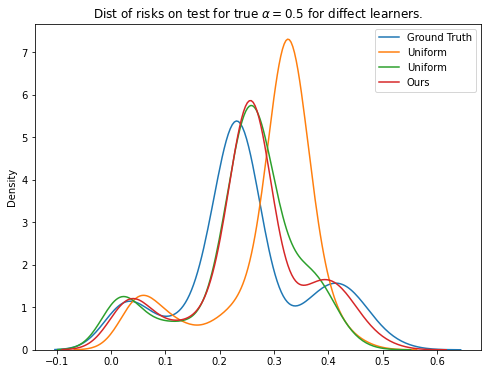

In [23]:
true_alpha=0.5
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8,6))

ground_truth_f = FHatNetwork(dim,[],1).cuda()
ARM_Regression(name=rho).fit_f(ground_truth_f, data_dict_train, true_alpha) 

with torch.no_grad():
    train_risks = []
    for e in data_dict_test.keys():
        x, y = data_dict_test[e]['x'].cuda(), data_dict_test[e]['y'].cuda()
        train_risks.append(loss_fn(y, ground_truth_f(x)).cpu()) 
    train_risks = torch.stack(train_risks)
sns.kdeplot(train_risks.cpu().numpy(), ax=ax, label='Ground Truth')
groundtruth_cvar = aggregation_function(name="cvar").aggregate(train_risks, true_alpha)

with torch.no_grad():
    train_risks = []
    for e in data_dict_test.keys():
        x, y = data_dict_test[e]['x'].cuda(), data_dict_test[e]['y'].cuda()
        train_risks.append(loss_fn(y, f_unif(x)).cpu()) 
    train_risks = torch.stack(train_risks)
sns.kdeplot(train_risks.cpu().numpy(), ax=ax, label='Uniform')
uniform_cvar = aggregation_function(name="cvar").aggregate(train_risks, true_alpha)


with torch.no_grad():
    train_risks = []
    for e in data_dict_test.keys():
        x, y = data_dict_test[e]['x'].cuda(), data_dict_test[e]['y'].cuda()
        train_risks.append(loss_fn(y, f_dirac(x)).cpu()) 
    train_risks = torch.stack(train_risks)
sns.kdeplot(train_risks.cpu().numpy(), ax=ax, label='Uniform')
dirac_cvar = aggregation_function(name="cvar").aggregate(train_risks, true_alpha)

with torch.no_grad():
    train_risks = []
    for e in data_dict_test.keys():
        x, y = data_dict_test[e]['x'].cuda(), data_dict_test[e]['y'].cuda()
        train_risks.append(loss_fn(y, h(x,torch.tensor(true_alpha).cuda())).cpu()) 
    train_risks = torch.stack(train_risks)
sns.kdeplot(train_risks.cpu().numpy(), ax=ax, label='Ours')
our_cvar = aggregation_function(name="cvar").aggregate(train_risks, true_alpha)
ax.legend()
ax.set_title(r"Dist of risks on test for true $\alpha=$"+str(true_alpha)+" for diffect learners.")
norm = plt.Normalize(0.05, 0.95)
ax.get_legend()

In [24]:
print(groundtruth_cvar, dirac_cvar, uniform_cvar, our_cvar)

tensor(0.3270) tensor(0.3142) tensor(0.3463) tensor(0.3293)
